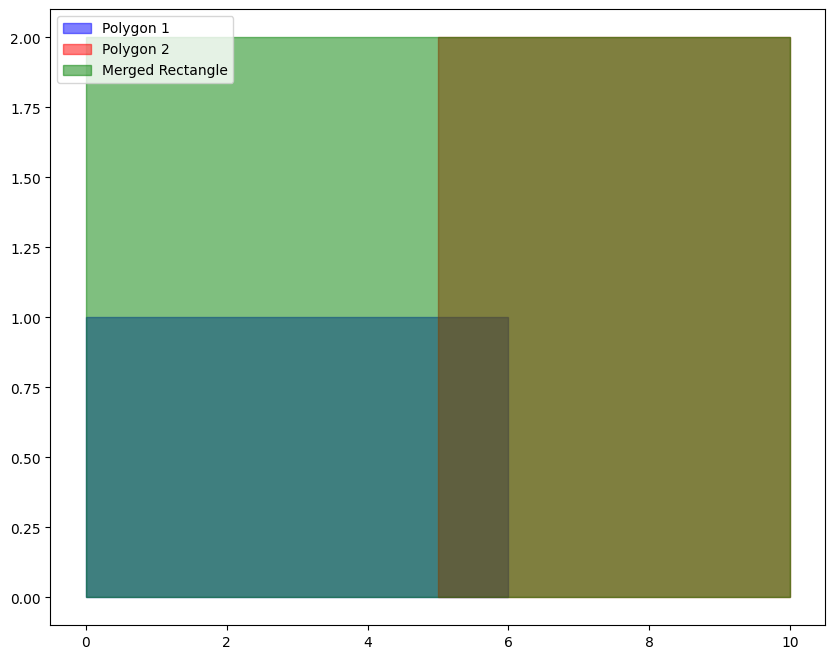

In [66]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# Define the two polygons (rectangles)
polygon1 = Polygon([(0, 0), (6, 0), (6, 1), (0, 1)])
polygon2 = Polygon([(5, 0), (10, 0), (10, 2), (5, 2)])

# Merge the two polygons and get the bounding box (always a rectangle)
merged_polygon = polygon1.union(polygon2).envelope

# Plot the polygons and the merged rectangle
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the individual polygons
x1, y1 = polygon1.exterior.xy
x2, y2 = polygon2.exterior.xy

ax.fill(x1, y1, color='blue', alpha=0.5, label="Polygon 1")
ax.fill(x2, y2, color='red', alpha=0.5, label="Polygon 2")

# Plot the merged rectangle
x_merged, y_merged = merged_polygon.exterior.xy
ax.fill(x_merged, y_merged, color='green', alpha=0.5, label="Merged Rectangle")

ax.set_aspect('equal', adjustable='box')  # Ensure equal aspect ratio
ax.set_xlim(-1, 12)  # Set x-axis limits
ax.set_ylim(-1, 3)  # Set y-axis limits
ax.legend()
plt.show()


In [149]:
from src.utils import bounding_box_to_polygon


def find_merge_intersections(line_segments = []):
    """
        Merge the lines if they intersect, have the same slope, and are adjacent.
    """
    merged_intersections = []
    i = 0
    while i < len(line_segments):
        j = i + 1
        while j < len(line_segments):
            x1, y1, _x1, _y1 = line_segments[i]
            x2, y2, _x2, _y2 = line_segments[j]
            current_line = bounding_box_to_polygon(x1, y1, _x1, _y1)
            next_line = bounding_box_to_polygon(x2, y2, _x2, _y2)

            def thick_line_slope(x1, y1, x2, y2):
                width = abs(x2 - x1)
                height = abs(y2 - y1)

                return 0 if width > height else float('inf')

            if current_line.intersects(next_line) and thick_line_slope(x1, y1, _x1, _y1) == thick_line_slope(x2, y2, _x2, _y2):
                merged_intersections.append((i, j))
            j += 1
        i += 1

    return merged_intersections

In [150]:
lines = [
    [-8.0, 629.0, 51.0, 625.0],
    [160.0, 915.0, 457.0, 911.0],
    [451.0, 918.0, 455.0, 799.0],
    [166.0, 1145.0, 170.0, 906.0],
    [228.0, 345.0, 461.0, 341.0],
    [736.0, 972.0, 740.0, 619.0],
    [451.0, 670.0, 455.0, 462.0],
    [451.0, 336.0, 455.0, 477.0],
    [447.0, 59.0, 553.0, 55.0],
    [105.0, 629.0, 175.0, 625.0],
    [161.0, 629.0, 433.0, 625.0],
    [474.0, 630.0, 540.0, 626.0],
    [166.0, 620.0, 170.0, 713.0],
    [166.0, 920.0, 170.0, 808.0],
    [630.0, 629.0, 745.0, 625.0],
    [736.0, 1145.0, 740.0, 1056.0],
    [451.0, 133.0, 455.0, 52.0],
    [450.0, 712.0, 454.0, 647.0],
    [517.0, 631.0, 566.0, 627.0],
    [451.0, 350.0, 455.0, 267.0],
    [438.0, 629.0, 497.0, 625.0],
    [410.0, 629.0, 468.0, 625.0]
]
merged_lines_index = find_merge_intersections(lines)

[(3, 13),
 (6, 7),
 (6, 17),
 (7, 19),
 (9, 10),
 (10, 21),
 (11, 18),
 (11, 20),
 (20, 21)]

In [152]:
from collections import defaultdict


def find_intersections_to_merge(merged_lines_index):
    intersections = merged_lines_index

    adj_list = defaultdict(set)
    for a, b in intersections:
        adj_list[a].add(b)
        adj_list[b].add(a)

    def find_connected_components(adj_list):
        visited = set()
        components = []

        def dfs(node, component):
            stack = [node]
            while stack:
                curr = stack.pop()
                if curr not in visited:
                    visited.add(curr)
                    component.append(curr)
                    stack.extend(adj_list[curr] - visited)

        for node in adj_list:
            if node not in visited:
                component = []
                dfs(node, component)
                components.append(sorted(component))  # Sort for consistency

        return components

    return find_connected_components(adj_list)

connected_components = find_intersections_to_merge(merged_lines_index)

In [153]:
merged_polygons = []
for connect_indexs in connected_components:
    x, y, _x, _y = lines[connect_indexs[0]]
    polygon = bounding_box_to_polygon(x, y, _x, _y)
    for con_index in connect_indexs[1:]:
        x, y, _x, _y = lines[con_index]
        new_polygon = bounding_box_to_polygon(x, y, _x, _y)
        polygon = polygon.union(new_polygon)
    polygon = polygon.envelope
    merged_polygons.append(polygon.bounds)

merged_polygons

[(166.0, 808.0, 170.0, 1145.0),
 (450.0, 267.0, 455.0, 712.0),
 (105.0, 625.0, 566.0, 631.0)]

In [154]:
connected_components

[[3, 13], [6, 7, 17, 19], [9, 10, 11, 18, 20, 21]]

C:\Users\GenAI\AppData\Local\Temp\ipykernel_29388\3581208061.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


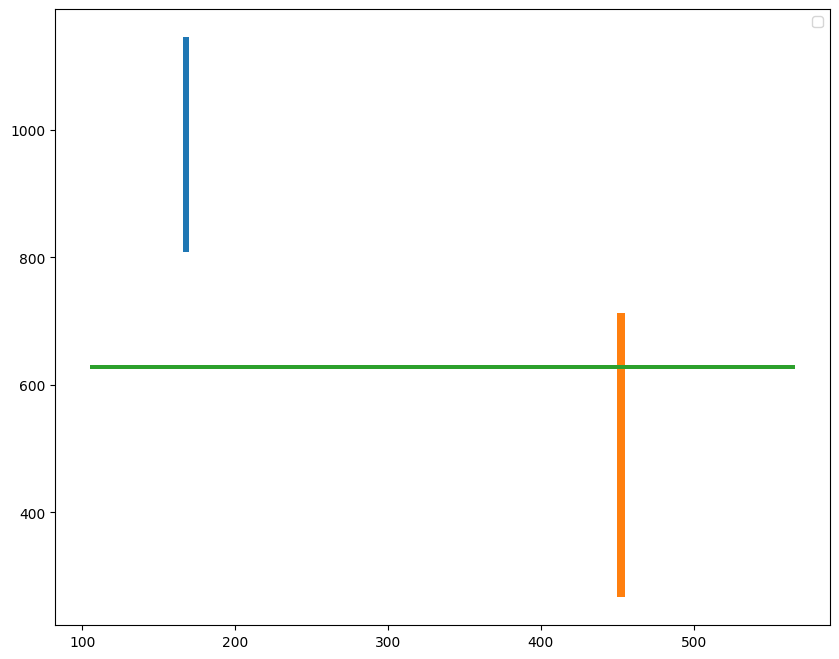

In [145]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

for point in merged_polygons:
    tl, tr, bl, br = (point[0], point[1]), (point[2], point[1]), (point[0], point[3]), (point[2], point[3])
    p = Polygon([bl, br, tr, tl])
    x1, y1 = p.exterior.xy
    ax.fill(x1, y1)

ax.legend()
plt.show()